<a href="https://colab.research.google.com/github/syankov-ai/Medium/blob/main/Thompson_Sampling_Waffle_Advertisement.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Simulate initial round

In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
# Set seed for reproducibility
np.random.seed(42)

# Parameters
num_arms = 3                # Number of variants/arms
warmup_iterations = 10000   # Number of iterations for initial data collection

# True probabilities for each arm (unknown to the bandit initially)
true_conversion_rates = [0.10, 0.15, 0.20]

# Initialize dictionary to store rewards during warm-up
initial_rewards = {f'arm_{i}': [] for i in range(num_arms)}

# Simulate warm-up phase: generate synthetic rewards (click=1, no click=0)
for arm in range(num_arms):
    rewards = np.random.binomial(n=1, p=true_conversion_rates[arm], size=warmup_iterations)
    initial_rewards[f'arm_{arm}'] = rewards

# Convert to pandas DataFrame for ease of analysis
df_initial = pd.DataFrame(initial_rewards)

# Preview the first few rows of the collected data
# print(df_initial.count())
df_initial.head()


,arm_0,arm_1,arm_2
0,0,0,0
1,1,0,0
2,0,0,0
3,0,0,0
4,0,0,0


## Plot the Observed Data

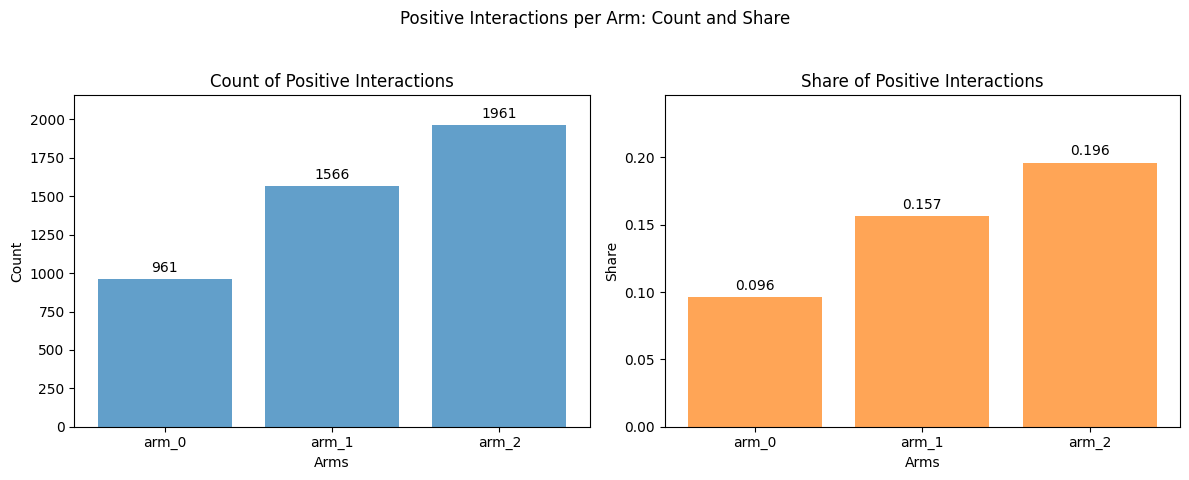

In [4]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Get statistics
positive_counts = df_initial.sum()
total_counts = df_initial.count()
positive_shares = positive_counts / total_counts

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))

bars1 = ax1.bar(positive_counts.index, positive_counts.values, color='tab:blue', alpha=0.7)
ax1.set_title('Count of Positive Interactions')
ax1.set_xlabel('Arms')
ax1.set_ylabel('Count')
max_count = positive_counts.max()
ax1.set_ylim(0, max_count + 0.1 * max_count)  # Set y-axis max just above highest bar

for bar in bars1:
    height = bar.get_height()
    ax1.annotate(f'{int(height)}',
                 xy=(bar.get_x() + bar.get_width() / 2, height),
                 xytext=(0, 3),
                 textcoords="offset points",
                 ha='center', va='bottom')

bars2 = ax2.bar(positive_shares.index, positive_shares.values, color='tab:orange', alpha=0.7)
ax2.set_title('Share of Positive Interactions')
ax2.set_xlabel('Arms')
ax2.set_ylabel('Share')
max_share = positive_shares.max()
ax2.set_ylim(0, max_share + 0.05)  # Set y-axis max just above highest bar

for bar in bars2:
    height = bar.get_height()
    ax2.annotate(f'{height:.3f}',
                 xy=(bar.get_x() + bar.get_width() / 2, height),
                 xytext=(0, 3),
                 textcoords="offset points",
                 ha='center', va='bottom')

plt.suptitle('Positive Interactions per Arm: Count and Share')
plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()


## Modeling

In [5]:
import numpy as np
import pandas as pd

class MultiArmedBanditThompsonLogged:
    """
    Multi-Armed Bandit using Thompson Sampling with logged binary interaction data.

    This class models learning and selection of the best arm (e.g., ad variant) to maximize rewards,
    using the Bayesian Thompson Sampling approach. Rather than simulating rewards,
    it uses a real or synthetic reward log stored as a DataFrame.
    """

    def __init__(self, df, n_steps=None):
        """
        Args:
            df (pd.DataFrame): DataFrame with shape (num_trials, num_arms):
                Each column represents an arm (variant).
                Each row represents feedback from one user/trial (1=success/click, 0=failure/no click).
            n_steps (int, optional): Number of trials to run (default: number of rows in df).
        """
        self.df = df

        # Use all data by default if n_steps not specified
        self.n_steps = n_steps if n_steps is not None else len(df)
        self.num_arms = df.shape[1]  # Number of variants/arms

    def run_thompson_sampling(self):
        """
        Runs the Thompson Sampling algorithm for n_steps using logged rewards.

        Returns:
            chosen_arms (list): Sequence of indices of chosen arms at each iteration.
            rewards (list): List of collected rewards at each iteration (0 or 1).
            successes (np.array): Total number of successes per arm after all rounds.
            failures (np.array): Total number of failures per arm after all rounds.
        """
        # For each arm, track the count of observed successes and failures (click/no click)
        successes = np.zeros(self.num_arms, dtype=int)
        failures = np.zeros(self.num_arms, dtype=int)

        # Containers to log arm choices, collected rewards and beta history
        chosen_arms = []
        rewards = []
        beta_history = []

        # Go through each user interaction (trial)
        for n in range(self.n_steps):
            # For each arm, sample from its Beta posterior (parameters: successes+1, failures+1)
            # This reflects our belief about each arm's click probability, incorporating all observed feedback so far.
            sampled_rates = [np.random.beta(successes[i] + 1, failures[i] + 1)
                             for i in range(self.num_arms)]

            # Select the arm with the highest sampled rate (probabilistically balancing exploration/exploitation)
            chosen_arm = np.argmax(sampled_rates)
            chosen_arms.append(chosen_arm)

            # For the chosen arm, fetch the logged reward for this user/trial
            reward = self.df.values[n, chosen_arm]
            rewards.append(reward)

            # Update the posterior for this arm:
            if reward == 1:
                successes[chosen_arm] += 1  # Increment successes if reward observed
            else:
                failures[chosen_arm] += 1   # Increment failures otherwise

            # Update the beta history with the current state of the success and failure counts for all arms
            beta_history.append((successes.copy(), failures.copy()))

        # After all rounds, return the entire trajectory and stats for later analysis or plotting
        return chosen_arms, rewards, successes, failures, beta_history


In [9]:
# Instantiate the bandit with your interaction DataFrame
mab = MultiArmedBanditThompsonLogged(df=df_initial)

# Run the Thompson Sampling simulation
chosen_arms, rewards, successes, failures, beta_history = mab.run_thompson_sampling()

# Print final counts of successes and failures per arm
print(f"Successes per arm: {successes}")
print(f"Failures per arm: {failures}")

# Total reward achieved
total_reward = np.sum(rewards)
print(f"Total reward (clicks): {total_reward}")


Successes per arm: [  14   33 1904]
Failures per arm: [ 112  201 7736]
Total reward (clicks): 1951


## Plot the variants

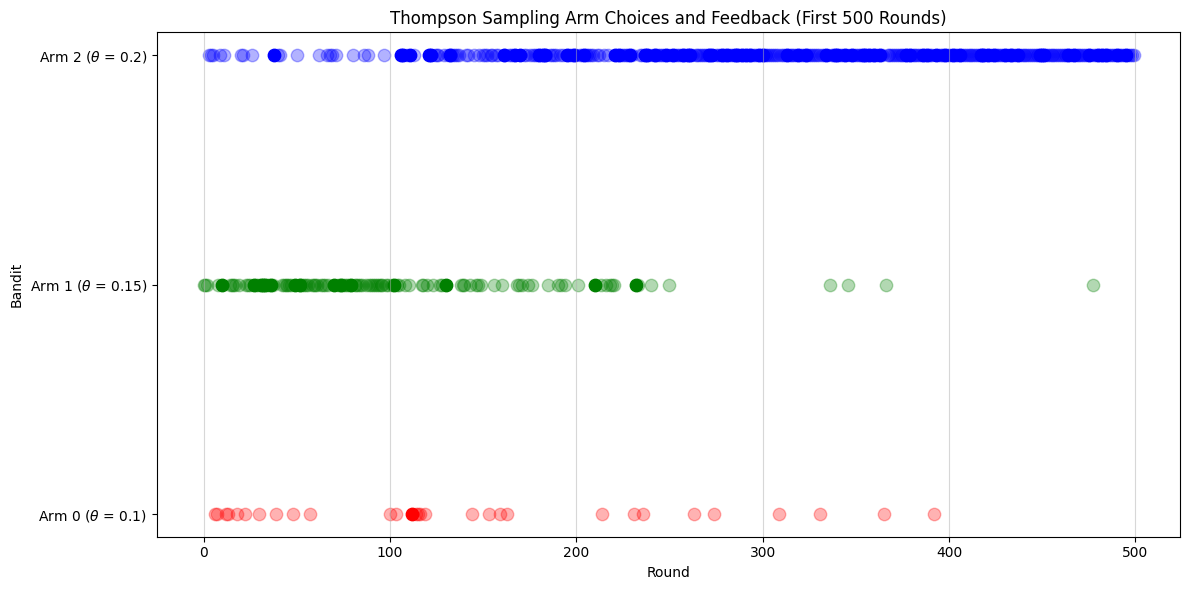

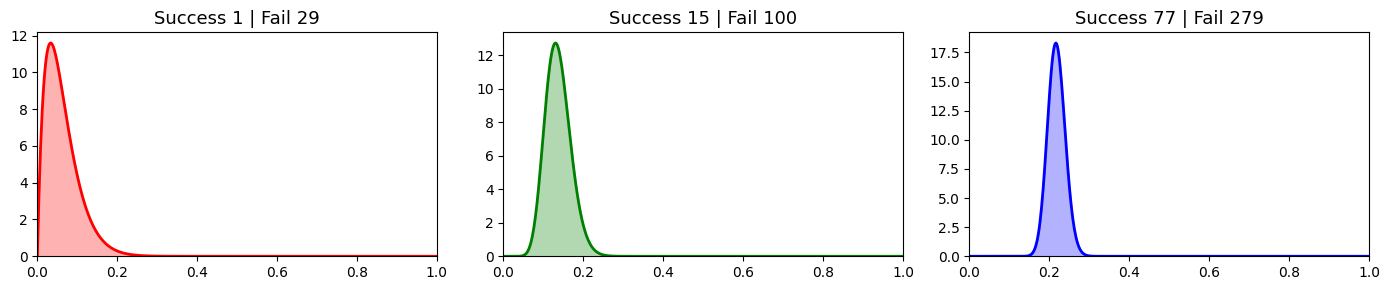

In [11]:
from scipy.stats import beta

distribution_colors = ['red', 'green', 'blue']

# n_steps = warmup_iterations
n_steps = 500

# Plotting arm choices: colored for correct, faded for incorrect
plt.figure(figsize=(12,6))
for arm in range(num_arms):
    arm_draws = [i for i in range(n_steps) if chosen_arms[i] == arm]
    correct_draws = [i for i in arm_draws if rewards[i] == 1]
    incorrect_draws = [i for i in arm_draws if rewards[i] == 0]
    plt.scatter(correct_draws, [arm]*len(correct_draws), color=distribution_colors[arm], label=f'Arm {arm} correct' if arm==0 else "", s=80, alpha=1, marker='o')
    plt.scatter(incorrect_draws, [arm]*len(incorrect_draws), color=distribution_colors[arm], s=80, alpha=0.3, marker='o')
plt.yticks(range(num_arms), [f"Arm {i} ($\\theta$ = {true_conversion_rates[i]})" for i in range(num_arms)])
plt.xlabel("Round")
plt.ylabel("Bandit")
plt.title(f"Thompson Sampling Arm Choices and Feedback (First {n_steps} Rounds)")
plt.grid(True, axis='x', alpha=0.5)
plt.tight_layout()
plt.show()

# Plot Beta distributions for each arm at round 50
x = np.linspace(0, 1, 500)
fig, axs = plt.subplots(1, num_arms, figsize=(14,3))
final_success, final_failure = beta_history[n_steps]
for arm in range(num_arms):
    y = beta.pdf(x, final_success[arm]+1, final_failure[arm]+1)
    axs[arm].plot(x, y, color=distribution_colors[arm], lw=2)
    axs[arm].fill_between(x, 0, y, color=distribution_colors[arm], alpha=0.3)
    axs[arm].set_title(f'Success {final_success[arm]} | Fail {final_failure[arm]}', fontsize=13)
    axs[arm].set_xlim(0, 1)
    axs[arm].set_ylim(0)
plt.tight_layout()
plt.show()